# Galaxy10 DECals Anomaly Detection

**Author**: Phanuphat (Oad) Srisukhawasu <br>
**Date**: December 8, 2024

In this project, we will investigate anomalies in the Galaxy10 DECals dataset, a detailed collection of galaxy images from extensive sky surveys. Initially, we apply ResNet50 pretrained weights to encode the images as linear features. We then experiment with various anomaly detection techniques, including autoencoders, k-means clustering, and DBSCAN. By establishing thresholds for outliers, we identify common anomalies across methods. The final output highlights images that exhibit potential deviations from typical galaxies, presenting opportunities for further exploration.

##  Setup and Imports

The following code sets up the necessary dependencies and parameters for image processing and anomaly detection.

In [1]:
# Import Dependencies
import os
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torchvision import transforms, models

try:
    from astroNN.datasets import load_galaxy10
except ImportError:
    !pip install astronn
    from astroNN.datasets import load_galaxy10

from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

try:
    import colorama
    from colorama import Fore, Style
except ImportError:
    !pip install colorama
    import colorama
    from colorama import Fore, Style

from typing import Tuple, Optional

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 81.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 83.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 94.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.7/738.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 50.4 MB/s eta 0:00:00


In [2]:
# Global Parameters
IMG_SIZE = 128
BATCH_SIZE = 32
RANDOM_SEED = 202412

torch.manual_seed(RANDOM_SEED)
colorama.init(autoreset=True)

## Dataset Preparation

This section defines the preprocessing and dataset handling for the Galaxy10 images.

- `get_transforms()`: A function that returns a series of transformations to preprocess the images, including resizing, converting to tensor format, and normalizing the pixel values.
  
- `GalaxyDataset`: A custom PyTorch dataset class for loading and transforming the Galaxy10 images. It stores the images and labels, and applies the defined transformations when retrieving individual samples.

- `load_galaxy_dataset()`: A function to load the Galaxy10 dataset, apply the transformations, and split it into training and testing sets. It returns two `DataLoader` objects for easy batch processing during model training and evaluation.

In [3]:
def get_transforms() -> transforms.Compose:
    """Image preprocessing transformations"""
    return transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    )


class GalaxyDataset(Dataset):
    """PyTorch Dataset for Galaxy10 images."""

    def __init__(
        self, images: np.ndarray, labels: np.ndarray, transform: transforms.Compose
    ) -> None:
        self.images = images.astype(np.uint8)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self) -> int:
        """Dataset size"""
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """Retrieve a dataset sample"""
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


def load_galaxy_dataset(test_size: float = 0.1) -> Tuple[DataLoader, DataLoader]:
    """Load Galaxy10 and split data"""
    images, labels = load_galaxy10()
    transform = get_transforms()
    dataset = GalaxyDataset(images, labels, transform=transform)
    train_size = int(len(dataset) * (1 - test_size))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, test_loader

## Feature Extraction

This section defines functions for creating a feature extractor and extracting features from the dataset.

- **`create_feature_extractor()`**: This function creates a feature extractor using a pretrained ResNet50 model. It removes the final classification layer to obtain the output of the last convolutional layer, which serves as a feature representation of the input images.

- **`extract_features()`**: A function to extract features from the dataset using the provided feature extractor. It processes the images in batches, passes them through the model, and stores the output features and corresponding labels. The function returns the extracted features and labels as NumPy arrays for further analysis.

In [4]:
def create_feature_extractor() -> nn.Sequential:
    """Create a feature extractor based on ResNet50."""
    pretrained_model = models.resnet50(weights="DEFAULT")
    feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-1])
    feature_extractor.eval()
    return feature_extractor


def extract_features(
    dataloader: DataLoader, model: nn.Module, device: str = "cuda"
) -> Tuple[np.ndarray, np.ndarray]:
    """Extract features from a given dataloader using the feature extractor."""
    model.to(device)
    features, labels = [], []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images).squeeze()
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())

    return np.vstack(features), np.hstack(labels)

## Autoencoder-Based Anomaly Detection

This section defines the Autoencoder model and functions for training and anomaly detection based on reconstruction errors.

- **`Autoencoder`**: A neural network class that implements an autoencoder with an encoder-decoder architecture. The encoder reduces the input features to a lower-dimensional latent space, and the decoder reconstructs the original features from this latent representation.

- **`train_autoencoder()`**: A function to train the autoencoder model. It uses the Mean Squared Error (MSE) loss function and the Adam optimizer to minimize reconstruction errors over multiple epochs.

- **`compute_reconstruction_errors()`**: A function to compute the reconstruction errors for the test features, which are used to identify how well the autoencoder reconstructs the input data.

- **`set_anomaly_threshold_iqr()`**: A function that calculates the anomaly detection threshold using the Interquartile Range (IQR) method. It computes the upper bound based on the 75th percentile and a factor of 1.5 times the IQR.

- **`detect_anomalies_from_threshold_iqr()`**: This function identifies anomalies by comparing the reconstruction errors against the threshold set by the IQR method. If the reconstruction error exceeds the threshold, it flags the data point as an anomaly.

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim: int = 2048, latent_dim: int = 64) -> None:
        """Initialize Autoencoder model"""
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the autoencoder"""
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


def train_autoencoder(
    train_features: np.ndarray,
    epochs: int = 50,
    lr: float = 1e-4,
) -> nn.Module:
    """Train the autoencoder"""
    device = "cuda" if torch.cuda.is_available() else "cpu"

    autoencoder = Autoencoder(input_dim=train_features[0].shape[0])
    autoencoder.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

    for epoch in range(epochs):
        autoencoder.train()
        epoch_loss = 0
        for batch in train_features:
            batch = torch.tensor(batch, dtype=torch.float32).to(device)
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_features)}")

    return autoencoder


def compute_reconstruction_errors(
    autoencoder: nn.Module,
    test_features: np.ndarray,
) -> torch.Tensor:
    """Compute reconstruction errors for test features"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    autoencoder.eval()
    test_features_tensor = torch.tensor(test_features, dtype=torch.float32).to(device)

    with torch.no_grad():
        reconstructed_features = autoencoder(test_features_tensor)

    return (
        torch.mean((test_features_tensor - reconstructed_features) ** 2, dim=1)
        .cpu()
        .numpy()
    )


def set_anomaly_threshold_iqr(reconstruction_errors: np.ndarray) -> float:
    """Set the threshold for anomaly detection using the interquartile range (IQR)"""
    q1 = np.percentile(reconstruction_errors, 25)
    q3 = np.percentile(reconstruction_errors, 75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    print(f"IQR: {iqr}, Q1: {q1}, Q3: {q3}, Anomaly detection threshold: {upper_bound}")
    return upper_bound


def detect_anomalies_from_threshold_iqr(
    reconstruction_errors: np.ndarray, threshold: float
) -> np.ndarray:
    """Detect anomalies based on reconstruction errors exceeding the IQR-based threshold"""
    anomalies = reconstruction_errors > threshold
    return anomalies

## Clustering-Based Anomaly Detection

This section defines clustering-based anomaly detection using K-means and DBSCAN.

- **`perform_kmeans()`**: A function that applies the K-means clustering algorithm to the input features. It returns the cluster assignments and the cluster centers.

- **`perform_dbscan()`**: A function that applies DBSCAN (Density-Based Spatial Clustering of Applications with Noise) for anomaly detection. It estimates the `eps` parameter (distance threshold) using nearest neighbors if not provided. It returns the cluster assignments, the number of clusters, and the number of noise points.

- **`detect_anomalies()`**: A function to detect anomalies using either the K-means or DBSCAN clustering method. It scales the input features and, depending on the chosen method:
  - **K-means**: It calculates the distance of each point to its cluster centroid and identifies outliers using the Interquartile Range (IQR) method.
  - **DBSCAN**: It identifies anomalies as points classified as noise (i.e., assigned to the `-1` cluster).

The function returns a boolean array where `True` indicates an anomaly.

In [6]:
def perform_kmeans(
    features: np.ndarray, n_clusters: int = 10
) -> Tuple[np.ndarray, np.ndarray, float]:
    """Perform K-means clustering"""
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(features)
    return clusters, kmeans.cluster_centers_


def perform_dbscan(
    features: np.ndarray, eps: Optional[float] = None, min_samples: int = 5
) -> Tuple[np.ndarray, int, int]:
    """Perform DBSCAN clustering with simple eps estimation"""
    if eps is None:
        nn = NearestNeighbors(n_neighbors=min_samples)
        nn.fit(features)
        distances, _ = nn.kneighbors(features)

        eps = np.median(distances[:, -1])

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(features)
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = list(clusters).count(-1)

    return clusters, n_clusters, n_noise


def detect_anomalies(
    features: np.ndarray, method: str = "kmeans", **kwargs: Optional[dict]
) -> np.ndarray:
    """Detect anomalies using clustering-based approach"""
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    if method == "kmeans":
        clusters, centroids = perform_kmeans(scaled_features, **kwargs)
        distances = np.linalg.norm(features - centroids[clusters], axis=1)
        q1 = np.percentile(distances, 25, axis=0)
        q3 = np.percentile(distances, 75, axis=0)
        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        return (distances < lower_bound) | (distances > upper_bound)

    if method == "dbscan":
        clusters, _, _ = perform_dbscan(scaled_features, **kwargs)
        return clusters == -1

    raise ValueError(f"Unsupported clustering method: {method}")

## Evaluation and Visualization

This section contains functions for visualizing and reporting anomalies detected in a dataset.

- **`visualize_anomalies()`**: 
  - Visualizes a subset of images flagged as anomalies.
  - Selects anomaly indices and displays them in a grid format (5 columns by default), showing the image, its label, and an anomaly ID.
  - If there are too many anomalies, it limits the display to a maximum (`max_to_display`).
  - Saves the visualization to the specified `output_path` and also shows the plot.

- **`visualize_latent_space()`**:
  - Visualizes the latent space of features using t-SNE (t-Distributed Stochastic Neighbor Embedding) to reduce the dimensionality of the features to 2D.
  - It uses the provided `clusters` to color-code the data points in the scatter plot.
  - Optionally saves the plot to a file (`save_path`), or displays it.

- **`save_anomaly_report()`**:
  - Saves a report detailing the anomaly detection results.
  - The report includes the total number of samples, the number of detected anomalies, and details of each anomaly (sample index and label).
  - The report is saved to the specified `save_path`.

In [7]:
def visualize_anomalies(images, labels, anomalies, output_path, max_to_display=10):
    """Visualize a subset of images flagged as anomalies."""
    anomaly_indices = np.where(anomalies == 1)[0]
    num_anomalies = len(anomaly_indices)

    if num_anomalies == 0:
        raise Exception("No anomalies to visualize.")

    if num_anomalies > max_to_display:
        anomaly_indices = random.sample(list(anomaly_indices), max_to_display)

    cols = 5
    rows = (len(anomaly_indices) // cols) + (len(anomaly_indices) % cols > 0)
    _, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()

    for i, idx in enumerate(anomaly_indices):
        img = images[idx]
        label = labels[idx]
        axes[i].imshow(img)
        axes[i].set_title(f"Anomaly ID: {idx}\nLabel: {label}")
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


def visualize_latent_space(
    features: np.ndarray, clusters: np.ndarray, save_path: Optional[str] = None
) -> None:
    """Visualize latent space using t-SNE"""
    tsne = TSNE(n_components=2)
    latent_2d = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=clusters, cmap="viridis")
    plt.title("Latent Space Clustering")
    plt.colorbar(scatter)

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()


def save_anomaly_report(
    features: np.ndarray, labels: np.ndarray, anomalies: np.ndarray, save_path: str
) -> None:
    """Save detailed anomaly detection report"""
    with open(save_path, "w") as f:
        f.write("Anomaly Detection Report\n")
        f.write("=====================\n\n")
        f.write(f"Total Samples: {len(features)}\n")
        f.write(f"Anomalies Detected: {np.sum(anomalies)}\n\n")

        f.write("Anomaly Details:\n")
        for i, (is_anomaly, label) in enumerate(zip(anomalies, labels)):
            if is_anomaly:
                f.write(f"Sample {i}: Label {label}\n")

## Put It All Together

The `main()` function orchestrates the galaxy anomaly detection pipeline. It starts by setting up the environment and loading the dataset. The pipeline proceeds to extract features, train an autoencoder, and detect anomalies using reconstruction errors, K-means, and DBSCAN methods. Anomalies are then visualized and reported. Key results are saved in the output directory, and selected anomalies are displayed. Finally, the process ends with a success message.

In [8]:
def print_header(message: str) -> None:
    """Print a stylized header with emoji."""
    print(f"\n{Fore.CYAN}🚀 {message} 🚀{Style.RESET_ALL}")


def print_success(message: str) -> None:
    """Print a success message with a green checkmark."""
    print(f"{Fore.GREEN}✅ {message}{Style.RESET_ALL}")


def print_info(message: str) -> None:
    """Print an informational message with a light bulb."""
    print(f"{Fore.BLUE}💡 {message}{Style.RESET_ALL}")


def main() -> None:
    print_header("Galaxy Anomaly Detection Pipeline Initiated!")
    output_dir = "anomaly_detection_results"

    os.makedirs(output_dir, exist_ok=True)
    print_info(f"Output directory created: {output_dir}")

    print_header("Loading Galaxy Dataset")
    train_loader, test_loader = load_galaxy_dataset()
    print_success(f"Loaded {len(train_loader.dataset)} training images")
    print_success(f"Loaded {len(test_loader.dataset)} test images")

    print_header("Extracting Features")
    feature_extractor = create_feature_extractor()
    train_features, _ = extract_features(train_loader, feature_extractor)
    test_features, test_labels = extract_features(test_loader, feature_extractor)
    print_success(
        f"Extracted features: Training set {train_features.shape}, Test set {test_features.shape}"
    )

    print_header("Training Autoencoder")
    autoencoder = train_autoencoder(train_features)
    print_success("Autoencoder training completed successfully!")

    print_header("Detecting Anomalies")
    reconstruction_losses = compute_reconstruction_errors(autoencoder, test_features)
    anomaly_threshold = set_anomaly_threshold_iqr(reconstruction_losses)
    reconstruction_losses_anomalies = detect_anomalies_from_threshold_iqr(
        reconstruction_losses, anomaly_threshold
    )
    kmeans_anomalies = detect_anomalies(test_features, method="kmeans")
    dbscan_anomalies = detect_anomalies(test_features, method="dbscan")
    common_anomalies = (
        reconstruction_losses_anomalies & kmeans_anomalies & dbscan_anomalies
    )

    print_success(
        f"Reconstruction Loss Anomalies Detected: {np.sum(reconstruction_losses_anomalies)}"
    )
    print_success(f"K-means Anomalies Detected: {np.sum(kmeans_anomalies)}")
    print_success(f"DBSCAN Anomalies Detected: {np.sum(dbscan_anomalies)}")
    print_success(
        f"Total Anomalies Detected (Intersection): {np.sum(common_anomalies)}"
    )

    print_header("Generating Visualizations")
    latent_space_path = os.path.join(output_dir, "latent_space.png")
    visualize_latent_space(test_features, test_labels, latent_space_path)
    print_success(f"Latent space visualization saved to {latent_space_path}")

    print_header("Saving Anomaly Reports")
    reconstruction_losses_report_path = os.path.join(
        output_dir, "reconstruction_losses_anomalies.txt"
    )
    kmeans_report_path = os.path.join(output_dir, "kmeans_anomalies.txt")
    dbscan_report_path = os.path.join(output_dir, "dbscan_anomalies.txt")

    save_anomaly_report(
        test_features,
        test_labels,
        reconstruction_losses_anomalies,
        reconstruction_losses_report_path,
    )
    save_anomaly_report(
        test_features, test_labels, kmeans_anomalies, kmeans_report_path
    )
    save_anomaly_report(
        test_features, test_labels, dbscan_anomalies, dbscan_report_path
    )

    print_info(
        f"Reconstruction Loss anomaly report saved to {reconstruction_losses_report_path}"
    )
    print_success(f"K-means anomaly report saved to {kmeans_report_path}")
    print_success(f"DBSCAN anomaly report saved to {dbscan_report_path}")

    print_header("Visualizing a Few Anomalies")
    anomaly_visualization_path = os.path.join(output_dir, "sampled_anomalies.png")
    visualize_anomalies(
        images=test_loader.dataset.dataset.images,
        labels=test_labels,
        anomalies=common_anomalies,
        output_path=anomaly_visualization_path,
        max_to_display=10,
    )

    print_header("Galaxy Anomaly Detection Pipeline Completed Successfully! 🌌")


🚀 Galaxy Anomaly Detection Pipeline Initiated! 🚀
💡 Output directory created: anomaly_detection_results

🚀 Loading Galaxy Dataset 🚀


Galaxy10_DECals.h5: 100%|█████████▉| 2.73G/2.74G [00:47<00:00, 58.9MB/s]   

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10_DECals.h5


Galaxy10_DECals.h5: 2.74GB [00:54, 50.3MB/s]                            


✅ Loaded 15962 training images
✅ Loaded 1774 test images

🚀 Extracting Features 🚀


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 226MB/s]


✅ Extracted features: Training set (15962, 2048), Test set (1774, 2048)

🚀 Training Autoencoder 🚀
Epoch 1/50, Loss: 0.05611441079307758
Epoch 2/50, Loss: 0.037774785110569885
Epoch 3/50, Loss: 0.03170307553435708
Epoch 4/50, Loss: 0.0298465573149078
Epoch 5/50, Loss: 0.02806270489601733
Epoch 6/50, Loss: 0.026943834752447472
Epoch 7/50, Loss: 0.026175024001308923
Epoch 8/50, Loss: 0.025540229576188116
Epoch 9/50, Loss: 0.0241438522309442
Epoch 10/50, Loss: 0.02324545436320891
Epoch 11/50, Loss: 0.022464827898410873
Epoch 12/50, Loss: 0.021893701101220932
Epoch 13/50, Loss: 0.021498897339785307
Epoch 14/50, Loss: 0.02106980127800555
Epoch 15/50, Loss: 0.020432368542087895
Epoch 16/50, Loss: 0.020026419354967243
Epoch 17/50, Loss: 0.019703173234672765
Epoch 18/50, Loss: 0.019315662634850822
Epoch 19/50, Loss: 0.01891568466626451
Epoch 20/50, Loss: 0.01863256939870042
Epoch 21/50, Loss: 0.018388126525450757
Epoch 22/50, Loss: 0.018178359805412013
Epoch 23/50, Loss: 0.017973992176614856
Ep

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


✅ Reconstruction Loss Anomalies Detected: 87
✅ K-means Anomalies Detected: 66
✅ DBSCAN Anomalies Detected: 767
✅ Total Anomalies Detected (Intersection): 9

🚀 Generating Visualizations 🚀
✅ Latent space visualization saved to anomaly_detection_results/latent_space.png

🚀 Saving Anomaly Reports 🚀
💡 Reconstruction Loss anomaly report saved to anomaly_detection_results/reconstruction_losses_anomalies.txt
✅ K-means anomaly report saved to anomaly_detection_results/kmeans_anomalies.txt
✅ DBSCAN anomaly report saved to anomaly_detection_results/dbscan_anomalies.txt

🚀 Visualizing a Few Anomalies 🚀


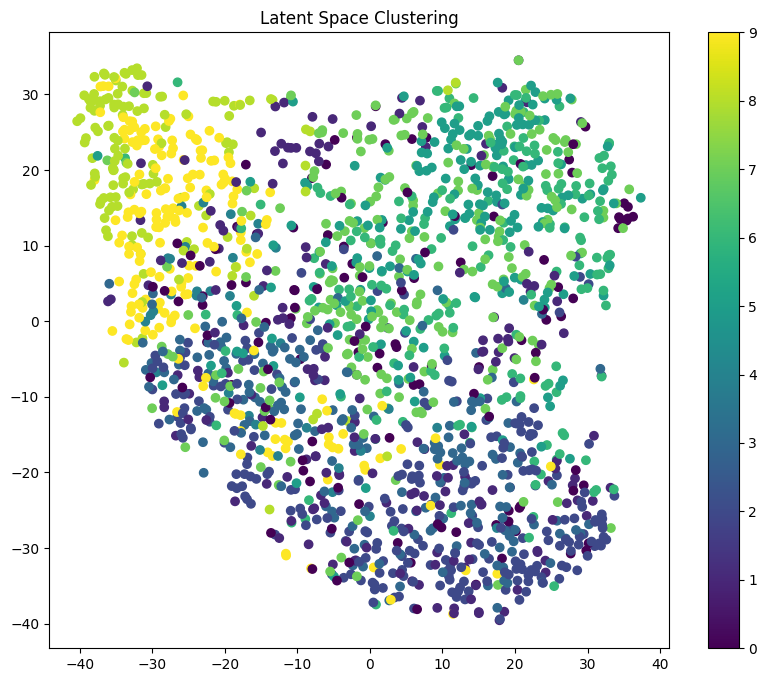

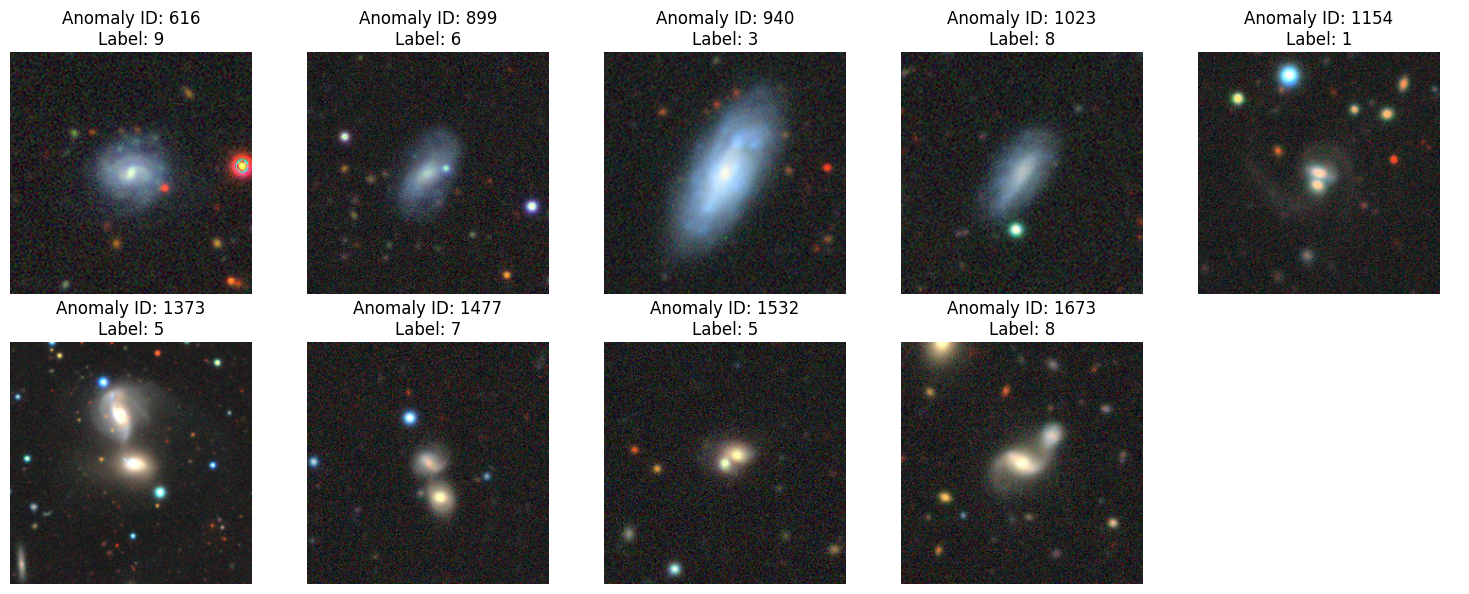


🚀 Galaxy Anomaly Detection Pipeline Completed Successfully! 🌌 🚀


In [9]:
# Run Entire Program
main()